In [18]:
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [13]:
web_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}
tickers = ['AMZN', 'GOOG', 'TSLA']
for tick in tickers:
    url = web_url+tick
    req = Request(url = url, headers = {"User-Agent":"Chrome"})
    response = urlopen(req)
    html = BeautifulSoup(response, "html.parser")
    news_table = html.find(id = 'news-table')
    news_tables[tick] = news_table

In [14]:
amazon = news_tables['AMZN']
amazon_tr = amazon.findAll('tr')

for x, table_row in enumerate(amazon_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if x == 3:
        break

How to get Amazon Prime for free  or at a major discount  right now
Oct-12-22 07:03AM
Amazons Prime Day redux sale ends today  and these are the 20 best deals, from KitchenAid stand mixers to Apple MacBook Air laptops
06:31AM
Amazon Shoppers Beware: Some 'Bargains' May Actually Cost You More
05:32AM
Why a 17-Mile Stretch of Arizona Highway Is a Booming Logistics Hub
05:30AM


In [15]:
news_list = []
for file_name, news_table in news_tables.items():
    for i in news_table.findAll('tr'):
        text = i.a.get_text()
        date_scrape = i.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        tick = file_name.split('_')[0]
        news_list.append([tick, date, time, text])        

In [19]:
vader = SentimentIntensityAnalyzer()
columns = ['ticker', 'date', 'time', 'headline']
news_df = pd.DataFrame(news_list, columns=columns)
scores = news_df['headline'].apply(vader.polarity_scores).to_list()
scores_df = pd.DataFrame(scores)
news_df = news_df.join(scores_df, rsuffix='_right')
news_df['date'] = pd.to_datetime(news_df.date).dt.date
news_df.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2022-10-12,07:03AM,How to get Amazon Prime for free or at a majo...,0.000,0.688,0.312,0.6124
1,AMZN,2022-10-12,06:31AM,Amazons Prime Day redux sale ends today and t...,0.042,0.798,0.160,0.6249
2,AMZN,2022-10-12,05:32AM,Amazon Shoppers Beware: Some 'Bargains' May Ac...,0.000,0.841,0.159,0.1779
3,AMZN,2022-10-12,05:30AM,Why a 17-Mile Stretch of Arizona Highway Is a ...,0.000,1.000,0.000,0.0000
4,AMZN,2022-10-12,05:19AM,3 Top Cloud Stocks to Buy in October,0.000,0.769,0.231,0.2023


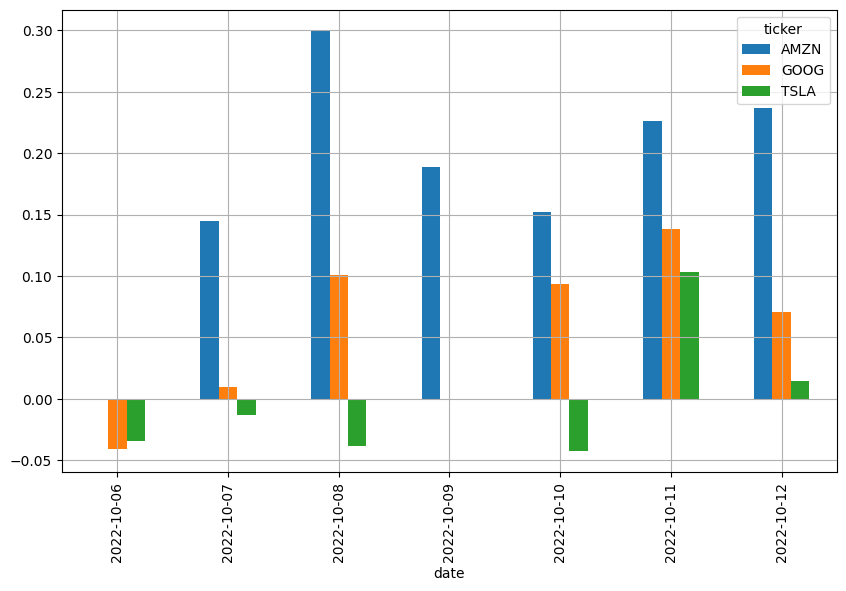

In [20]:
plt.rcParams['figure.figsize'] = [10,6]
mean_scores = news_df.groupby(['ticker', 'date']).mean()
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis = "columns").transpose()
mean_scores.plot(kind = 'bar')
plt.grid()
plt.show()